North Carolina weekly cases statistics: 

Mean weekly cases: 1444.286853265479
Median weekly cases: 237.0
Mode weekly cases:  0    0.0
Name: 0, dtype: float64


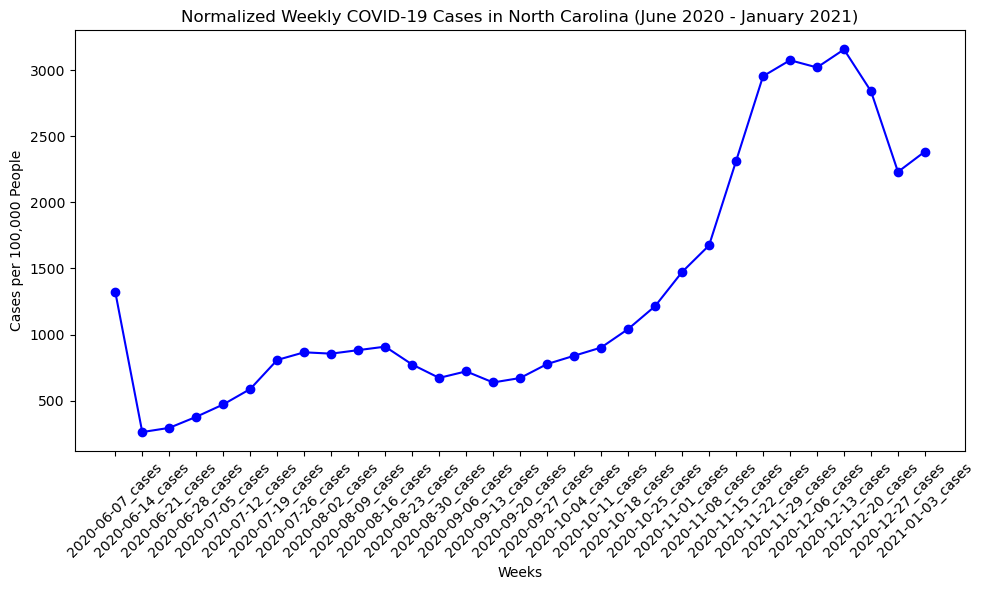



North Carolina weekly deaths statistics: 

Mean weekly deaths: 18.710008481764206
Median weekly deaths: 1.0
Mode weekly deaths:  0    0.0
Name: 0, dtype: float64


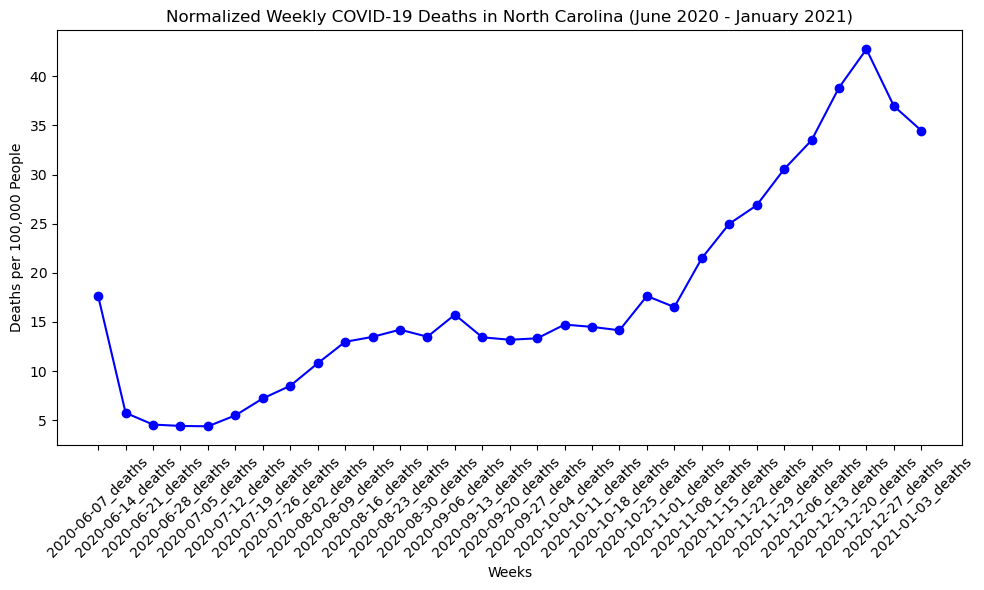

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the dataset
super_covid19_data = pd.read_csv('super_covid19_data.csv')

# Filter for cases and deaths between June 01, 2020, and January 3, 2021
start_date = '2020-06-01'
end_date = '2021-01-03'

# Separate cases and deaths columns
cases_columns = [col for col in super_covid19_data.columns if '_cases' in col and start_date <= col[:10] <= end_date]
deaths_columns = [col for col in super_covid19_data.columns if '_deaths' in col and start_date <= col[:10] <= end_date]

# Filter the dataset for the relevant columns (countyFIPS, State, County Name_x, population)
filtered_super_covid19_data = super_covid19_data[['countyFIPS', 'State', 'County Name_x', 'population'] + cases_columns + deaths_columns]

# US state abbreviations to filter: North Carolina, Minnesota, Hawaii, Florida, Kentucky, Vermont
states_to_keep = ['NC', 'MN', 'HI', 'FL', 'KY', 'VT']
filtered_super_covid19_data = filtered_super_covid19_data[filtered_super_covid19_data['State'].isin(states_to_keep)]

# Save the filtered dataset to a CSV file
filtered_super_covid19_data.to_csv('filtered_super_dates_June2020_Jan2021_and_6_states.csv', index=False)

# Filter case columns
case_columns = [col for col in filtered_super_covid19_data.columns if '_cases' in col]

# Transpose the case columns to resample by week
case_data = filtered_super_covid19_data[case_columns].T

# Convert column names (remove the suffix and convert to datetime)
case_data.index = pd.to_datetime([col[:10] for col in case_columns])

# Resample by week (summing cases for each week)
weekly_cases = case_data.resample('W-SUN').sum()

# Calculate the weekly differences to get non-cumulative data
weekly_non_cumulative_cases = weekly_cases.diff().fillna(weekly_cases.iloc[0])

# Transpose back and rename the columns to indicate weeks
weekly_non_cumulative_cases = weekly_non_cumulative_cases.T
weekly_non_cumulative_cases.columns = [str(col.date()) + '_cases' for col in weekly_non_cumulative_cases.columns]

# Combine with non-date columns that contain state and county info
weekly_non_cumulative_cases_super_covid19_data = pd.concat(
    [filtered_super_covid19_data[['countyFIPS', 'State', 'County Name_x', 'population']], 
     weekly_non_cumulative_cases], 
    axis=1)

# Remove rows that do not have info on the number of cases
weekly_non_cumulative_cases_super_covid19_data = weekly_non_cumulative_cases_super_covid19_data[
    weekly_non_cumulative_cases_super_covid19_data['countyFIPS'] != 0]

# Filter the death columns
death_columns = [col for col in filtered_super_covid19_data.columns if '_deaths' in col]

# Transpose the death columns to resample by week
death_data = filtered_super_covid19_data[death_columns].T

# Convert column names (remove the suffix and convert to datetime)
death_data.index = pd.to_datetime([col[:10] for col in death_columns])

# Resample by week (summing deaths for each week)
weekly_deaths = death_data.resample('W-SUN').sum()

# Calculate non-cumulative weekly deaths by taking the difference between consecutive weeks
non_cumulative_weekly_deaths = weekly_deaths.diff().fillna(weekly_deaths)

# Transpose back and rename the columns to indicate weeks
non_cumulative_weekly_deaths = non_cumulative_weekly_deaths.T
non_cumulative_weekly_deaths.columns = [str(col.date()) + '_deaths' for col in non_cumulative_weekly_deaths.columns]

# Combine with non-date columns that contain state and county info
non_cumulative_weekly_deaths_super_covid19_data = pd.concat([filtered_super_covid19_data[['countyFIPS', 'State', 'County Name_x', 'population']], non_cumulative_weekly_deaths], axis=1)

# Remove rows that do not have info on the number of deaths
non_cumulative_weekly_deaths_super_covid19_data = non_cumulative_weekly_deaths_super_covid19_data[non_cumulative_weekly_deaths_super_covid19_data['countyFIPS'] != 0]

# Remove rows that don't contain 'NC' in the State column
nc_weekly_cases = weekly_non_cumulative_cases_super_covid19_data
[weekly_non_cumulative_cases_super_covid19_data['State'].str.contains('NC') == True]

# Identify the columns for weekly cases
nc_weekly_case_columns = [col for col in nc_weekly_cases.columns if '_cases' in col]

# Calculate the average weekly cases for each county excluding the first week
county_avg_weekly_cases = nc_weekly_cases[nc_weekly_case_columns[1:]].mean(axis=1)

# Replace the first week's values with the calculated average for each county
nc_weekly_cases.loc[:, nc_weekly_case_columns[0]] = county_avg_weekly_cases

# Save a copy to use later for the 5 counties of my choice
nc_weekly_cases.to_csv('NC_weekly_cases.csv', index=False)

# The mean, median, and mode across all weeks
overall_mean = nc_weekly_cases[nc_weekly_case_columns].mean().mean()  
overall_median = nc_weekly_cases[nc_weekly_case_columns].median().median()  
nc_weekly_case_modes = nc_weekly_cases[nc_weekly_case_columns].mode().iloc[0]  # First mode value of all weeks

overall_mode = nc_weekly_case_modes.mode()

# Print the mean, median, and mode
print("North Carolina weekly cases statistics: \n")
print("Mean weekly cases:", overall_mean)
print("Median weekly cases:", overall_median)
print("Mode weekly cases: ", overall_mode)

# Normalize each week's cases by the population per 100,000 individuals for each county
normalized_nc_weekly_cases = nc_weekly_cases[nc_weekly_case_columns].div(nc_weekly_cases['population'], axis=0) * 100000

# Sum normalized cases for each week across all counties
nc_weekly_cases_normalized_sum = normalized_nc_weekly_cases.mean()

# Plot the normalized weekly cases
plt.figure(figsize=(10, 6))
plt.plot(nc_weekly_case_columns, nc_weekly_cases_normalized_sum, marker='o', linestyle='-', color='b')
plt.title('Normalized Weekly COVID-19 Cases in North Carolina (June 2020 - January 2021)')
plt.xlabel('Weeks')
plt.ylabel('Cases per 100,000 People')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('\n') #Weekly death stats below this

# Remove rows that don't contain 'NC' in the State column
nc_weekly_deaths = non_cumulative_weekly_deaths_super_covid19_data
[non_cumulative_weekly_deaths_super_covid19_data['State'].str.contains('NC') == True]

# Identify the columns for weekly deaths
nc_weekly_death_columns = [col for col in nc_weekly_deaths.columns if '_deaths' in col]

# Calculate the average weekly cases for each county excluding the first week
county_avg_weekly_deaths = nc_weekly_deaths[nc_weekly_death_columns[1:]].mean(axis=1)

# Replace the first week's values with the calculated average for each county
nc_weekly_deaths[nc_weekly_death_columns[0]] = county_avg_weekly_deaths

# Save a copy to use later for the 5 counties of my choice
nc_weekly_deaths.to_csv('NC_weekly_deaths.csv', index=False)

# The mean, median, and mode across all weeks for deaths
overall_mean_deaths = nc_weekly_deaths[nc_weekly_death_columns].mean().mean()  
overall_median_deaths = nc_weekly_deaths[nc_weekly_death_columns].median().median()  
weekly_death_modes = nc_weekly_deaths[nc_weekly_death_columns].mode().iloc[0]  # First mode value of all weeks

overall_mode_deaths = weekly_death_modes.mode()

# Print the mean, median, and mode for weekly deaths
print("North Carolina weekly deaths statistics: \n")
print("Mean weekly deaths:", overall_mean_deaths)
print("Median weekly deaths:", overall_median_deaths)
print("Mode weekly deaths: ", overall_mode_deaths)

# Normalize each week's deaths by the population per 100,000 individuals for each county
normalized_nc_weekly_deaths = nc_weekly_deaths[nc_weekly_death_columns].div(nc_weekly_deaths['population'], axis=0) * 100000

# Sum normalized deaths for each week across all counties
nc_weekly_deaths_normalized_sum = normalized_nc_weekly_deaths.mean()

# Plot the normalized weekly deaths
plt.figure(figsize=(10, 6))
plt.plot(nc_weekly_death_columns, nc_weekly_deaths_normalized_sum, marker='o', linestyle='-', color='b')
plt.title('Normalized Weekly COVID-19 Deaths in North Carolina (June 2020 - January 2021)')
plt.xlabel('Weeks')
plt.ylabel('Deaths per 100,000 People')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


MN weekly cases statistics:
Mean weekly cases: 1040.492337164751
Median weekly cases: 210.0
Mode weekly cases: 0.0

MN weekly deaths statistics:
Mean weekly deaths: 11.209961685823755
Median weekly deaths: 0.0
Mode weekly deaths: 0.0

--------------------------------------------------

HI weekly cases statistics:
Mean weekly cases: 840.7199999999999
Median weekly cases: 109.0
Mode weekly cases: 0.0

HI weekly deaths statistics:
Mean weekly deaths: 11.66666666666667
Median weekly deaths: 0.0
Mode weekly deaths: 0.0

--------------------------------------------------

FL weekly cases statistics:
Mean weekly cases: 4379.765671641791
Median weekly cases: 1296.0
Mode weekly cases: 40.0

FL weekly deaths statistics:
Mean weekly deaths: 66.29950248756218
Median weekly deaths: 27.0
Mode weekly deaths: 0.0

--------------------------------------------------

KY weekly cases statistics:
Mean weekly cases: 497.72583333333336
Median weekly cases: 112.5
Mode weekly cases: 0.0

KY weekly deaths stat

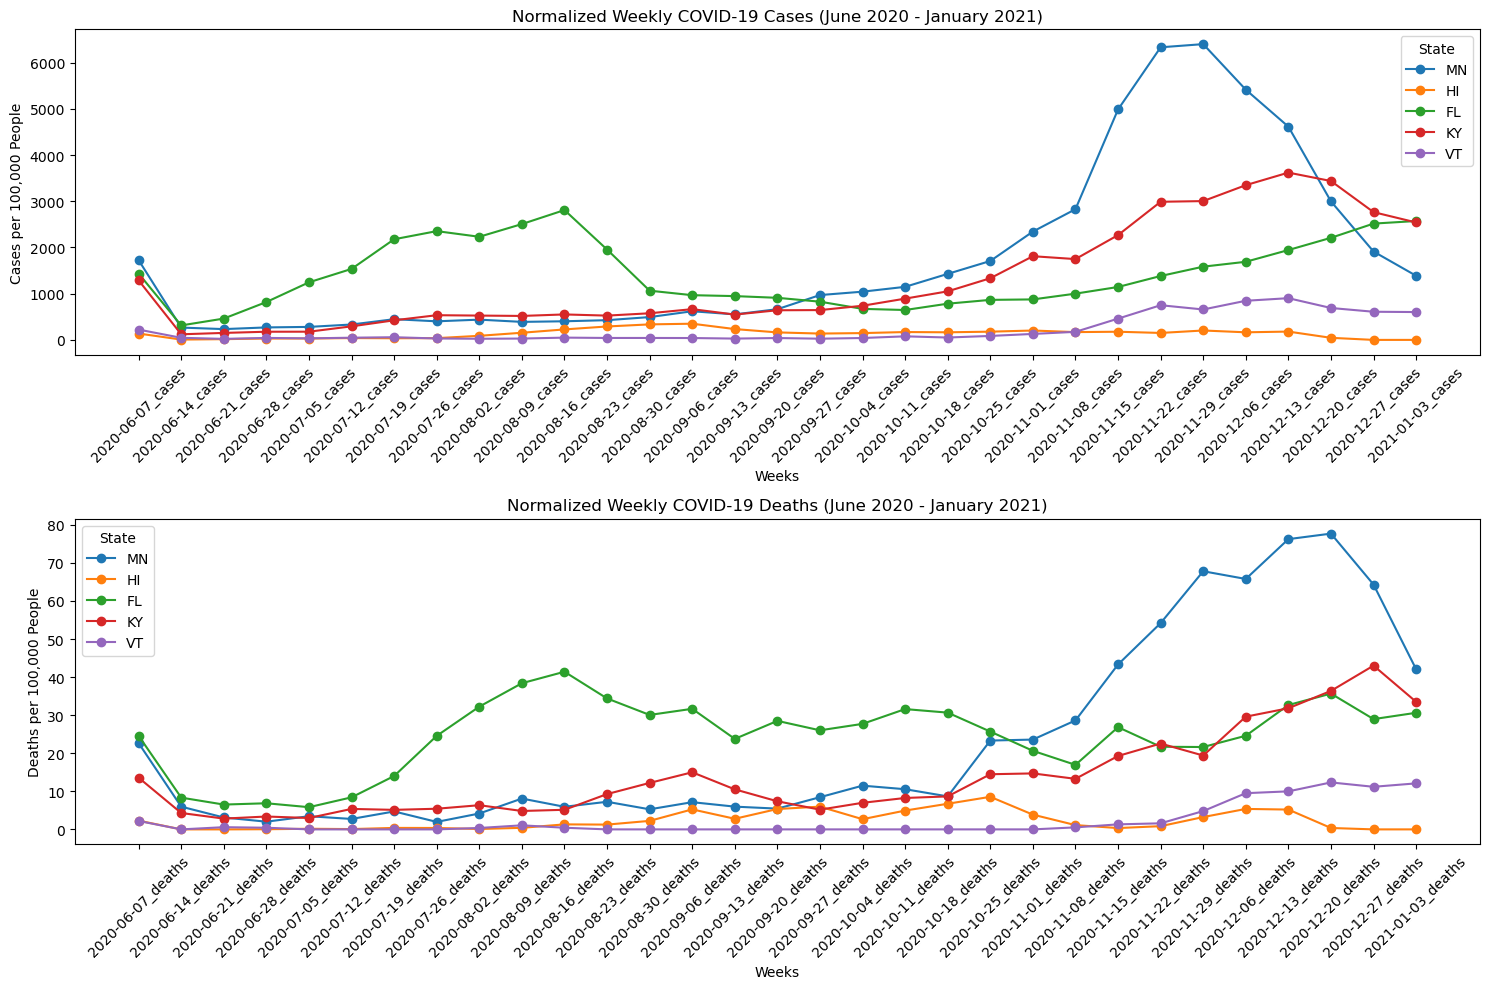

In [15]:
# Define the new set of states to plot
states = ['MN', 'HI', 'FL', 'KY', 'VT']

# Create figure for combined plots
plt.figure(figsize=(15, 10))

# Iterate through each state and calculate weekly statistics
for state in states:
    # Filter for the specific state
    state_weekly_cases = weekly_non_cumulative_cases_super_covid19_data[
        weekly_non_cumulative_cases_super_covid19_data['State'].str.contains(state) == True
    ]
    state_weekly_deaths = non_cumulative_weekly_deaths_super_covid19_data[
        non_cumulative_weekly_deaths_super_covid19_data['State'].str.contains(state) == True
    ]

    # Identify the columns for weekly cases and deaths
    weekly_case_columns = [col for col in state_weekly_cases.columns if '_cases' in col]
    weekly_death_columns = [col for col in state_weekly_deaths.columns if '_deaths' in col]

    # Calculate the average weekly cases and deaths for each county excluding the first week
    county_avg_weekly_cases = state_weekly_cases[weekly_case_columns[1:]].mean(axis=1)
    county_avg_weekly_deaths = state_weekly_deaths[weekly_death_columns[1:]].mean(axis=1)

    # Replace the first week's values with the calculated average for each county
    state_weekly_cases.loc[:, weekly_case_columns[0]] = county_avg_weekly_cases
    state_weekly_deaths.loc[:, weekly_death_columns[0]] = county_avg_weekly_deaths

    # Calculate mean, median, and mode for weekly cases
    overall_mean_cases = state_weekly_cases[weekly_case_columns].mean().mean()  
    overall_median_cases = state_weekly_cases[weekly_case_columns].median().median()  
    state_weekly_case_modes = state_weekly_cases[weekly_case_columns].mode().iloc[0]  # First mode value of all weeks
    overall_mode_cases = state_weekly_case_modes.mode()[0]  # Mode of the mode values

    # Calculate mean, median, and mode for weekly deaths
    overall_mean_deaths = state_weekly_deaths[weekly_death_columns].mean().mean()  
    overall_median_deaths = state_weekly_deaths[weekly_death_columns].median().median()  
    state_weekly_death_modes = state_weekly_deaths[weekly_death_columns].mode().iloc[0]  # First mode value of all weeks
    overall_mode_deaths = state_weekly_death_modes.mode()[0]  # Mode of the mode values

    # Print statistics for the current state
    print(f"{state} weekly cases statistics:")
    print("Mean weekly cases:", overall_mean_cases)
    print("Median weekly cases:", overall_median_cases)
    print("Mode weekly cases:", overall_mode_cases)
    print()

    print(f"{state} weekly deaths statistics:")
    print("Mean weekly deaths:", overall_mean_deaths)
    print("Median weekly deaths:", overall_median_deaths)
    print("Mode weekly deaths:", overall_mode_deaths)
    print('\n' + '-'*50 + '\n')

    # Normalize weekly cases and deaths by population per 100,000 individuals
    normalized_weekly_cases = state_weekly_cases[weekly_case_columns].div(state_weekly_cases['population'], axis=0) * 100000
    normalized_weekly_deaths = state_weekly_deaths[weekly_death_columns].div(state_weekly_deaths['population'], axis=0) * 100000

    # Sum normalized cases and deaths for each week across all counties
    weekly_cases_normalized_sum = normalized_weekly_cases.mean()
    weekly_deaths_normalized_sum = normalized_weekly_deaths.mean()

    # Plot normalized weekly cases for the state
    plt.subplot(2, 1, 1)
    plt.plot(weekly_case_columns, weekly_cases_normalized_sum, marker='o', linestyle='-', label=state)
    plt.title('Normalized Weekly COVID-19 Cases (June 2020 - January 2021)')
    plt.xlabel('Weeks')
    plt.ylabel('Cases per 100,000 People')
    plt.xticks(rotation=45)
    plt.legend(title='State')

    # Plot normalized weekly deaths for the state
    plt.subplot(2, 1, 2)
    plt.plot(weekly_death_columns, weekly_deaths_normalized_sum, marker='o', linestyle='-', label=state)
    plt.title('Normalized Weekly COVID-19 Deaths (June 2020 - January 2021)')
    plt.xlabel('Weeks')
    plt.ylabel('Deaths per 100,000 People')
    plt.xticks(rotation=45)
    plt.legend(title='State')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In comparison eith the overall for united states it seems that the peaks defintiley align i believ because of all the travel for the holidays. 

North Carolina Counties in the dataset:
Alamance County 
Alexander County 
Alleghany County 
Anson County 
Ashe County 
Avery County 
Beaufort County 
Bertie County 
Bladen County 
Brunswick County 
Buncombe County 
Burke County 
Cabarrus County 
Caldwell County 
Camden County 
Carteret County 
Caswell County 
Catawba County 
Chatham County 
Cherokee County 
Chowan County 
Clay County 
Cleveland County 
Columbus County 
Craven County 
Cumberland County 
Currituck County 
Dare County 
Davidson County 
Davie County 
Duplin County 
Durham County 
Edgecombe County 
Forsyth County 
Franklin County 
Gaston County 
Gates County 
Graham County 
Granville County 
Greene County 
Guilford County 
Halifax County 
Harnett County 
Haywood County 
Henderson County 
Hertford County 
Hoke County 
Hyde County 
Iredell County 
Jackson County 
Johnston County 
Jones County 
Lee County 
Lenoir County 
Lincoln County 
McDowell County 
Macon County 
Madison County 
Martin County 
Mecklenburg County 
Mitchell

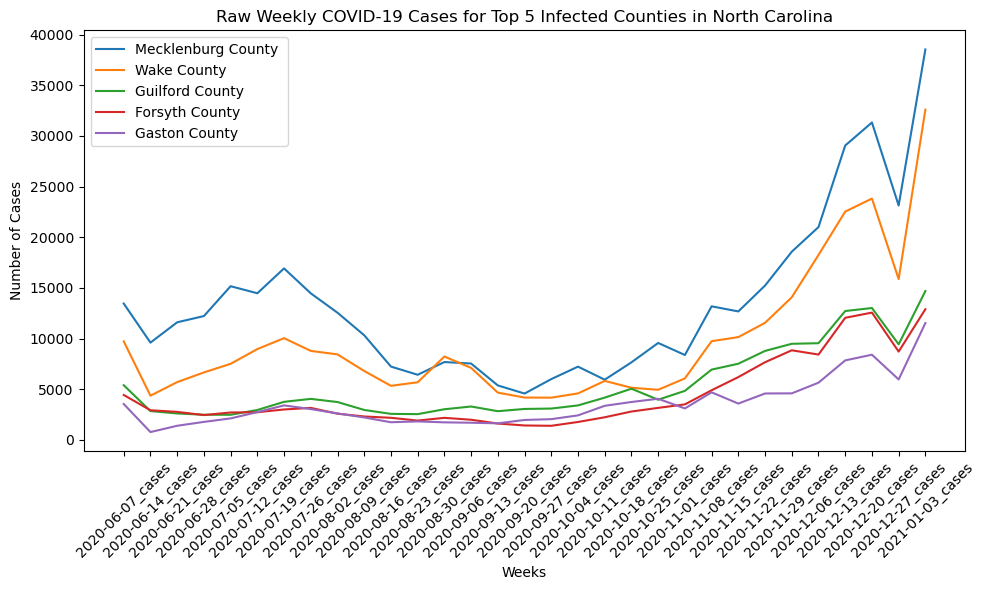

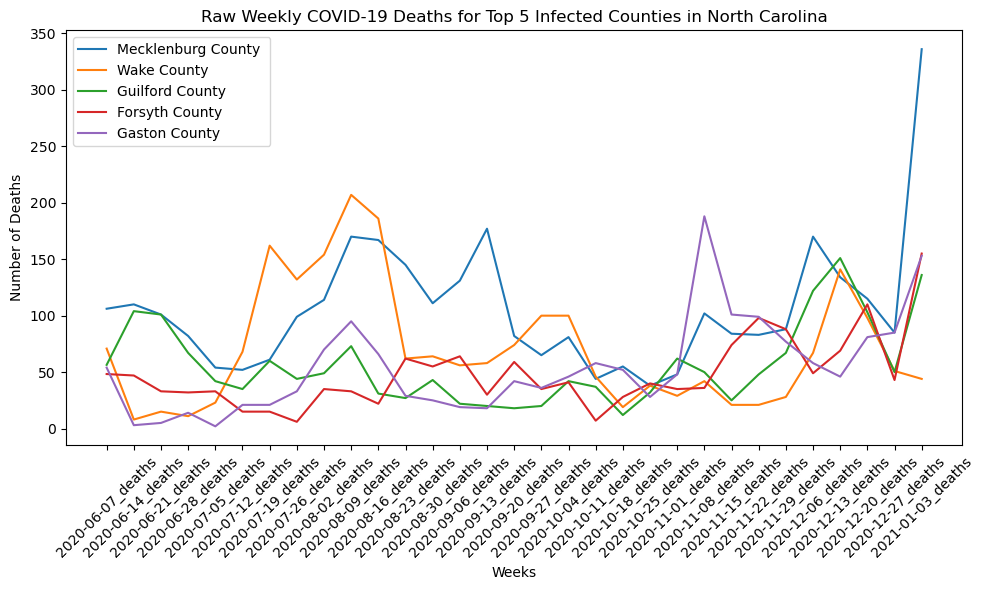

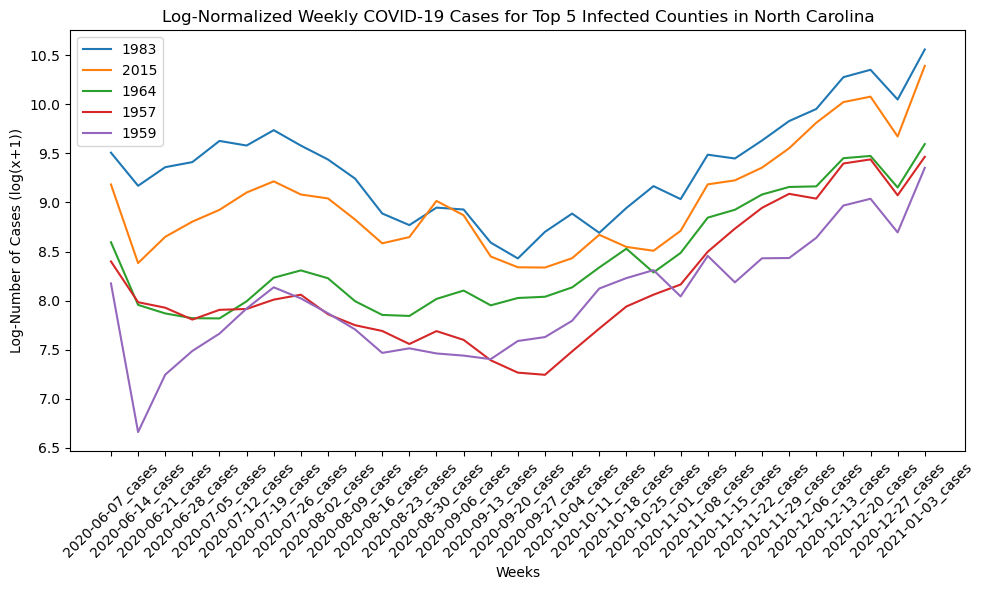

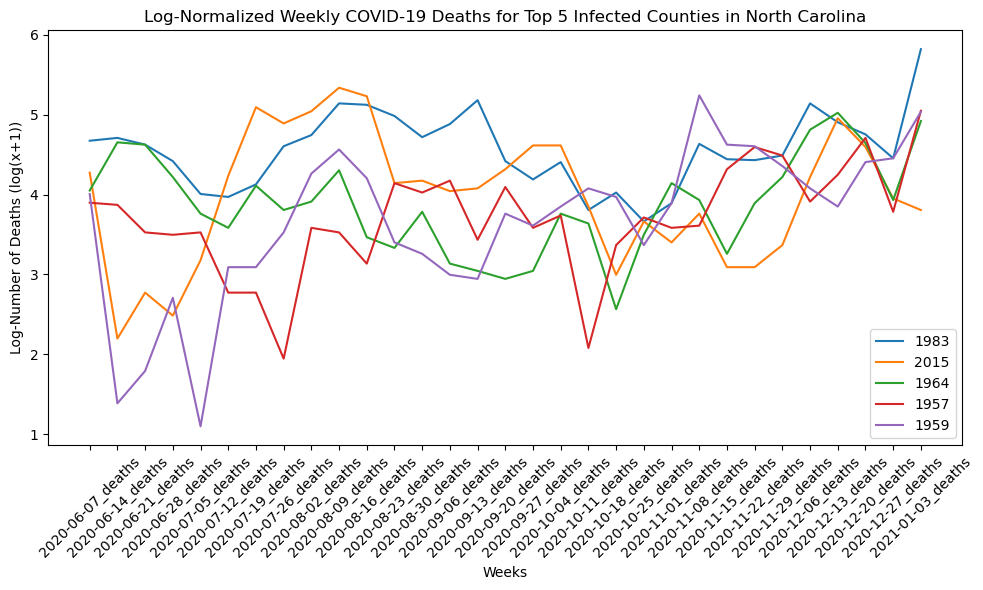

County: Mecklenburg County 
  Peak Weekly Cases: 38535.0 on 2021-01-03_cases
  Peak Weekly Deaths: 336.0 on 2021-01-03_deaths


County: Wake County 
  Peak Weekly Cases: 32599.0 on 2021-01-03_cases
  Peak Weekly Deaths: 207.0 on 2020-08-09_deaths


County: Guilford County 
  Peak Weekly Cases: 14696.0 on 2021-01-03_cases
  Peak Weekly Deaths: 151.0 on 2020-12-13_deaths


County: Forsyth County 
  Peak Weekly Cases: 12903.0 on 2021-01-03_cases
  Peak Weekly Deaths: 155.0 on 2021-01-03_deaths


County: Gaston County 
  Peak Weekly Cases: 11536.0 on 2021-01-03_cases
  Peak Weekly Deaths: 188.0 on 2020-11-08_deaths




In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Filter rows where the 'State' column is 'NC'
nc_counties_data_cases = nc_weekly_cases[nc_weekly_cases['State'] == 'NC']
nc_counties_data_deaths = nc_weekly_deaths[nc_weekly_deaths['State'] == 'NC']

# Get the names of the counties in North Carolina
nc_county_names = nc_counties_data_cases['County Name_x'].unique()

print("North Carolina Counties in the dataset:")
for county in nc_county_names:
    print(county)

# Calculate total cases for each county across all weeks
nc_weekly_case_columns = [col for col in nc_weekly_cases.columns if '_cases' in col]
total_cases_per_county = nc_counties_data_cases[nc_weekly_case_columns].sum(axis=1)

# Get the top 5 counties with the highest total cases
top_5_counties = total_cases_per_county.nlargest(5).index
top_5_case_data = nc_counties_data_cases.loc[top_5_counties]

# Repeat the process for deaths
nc_weekly_death_columns = [col for col in nc_weekly_deaths.columns if '_deaths' in col]
total_deaths_per_county = nc_counties_data_deaths[nc_weekly_death_columns].sum(axis=1)
top_5_death_data = nc_counties_data_deaths.loc[top_5_counties]

# Plot raw weekly cases for the top 5 infected counties in NC
plt.figure(figsize=(10, 6))
for county in top_5_case_data['County Name_x']:
    plt.plot(nc_weekly_case_columns, top_5_case_data.loc[top_5_case_data['County Name_x'] == county, nc_weekly_case_columns].values[0], label=county)

plt.title('Raw Weekly COVID-19 Cases for Top 5 Infected Counties in North Carolina')
plt.xlabel('Weeks')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot raw weekly deaths for the top 5 infected counties in NC
plt.figure(figsize=(10, 6))
for county in top_5_death_data['County Name_x']:
    plt.plot(nc_weekly_death_columns, top_5_death_data.loc[top_5_death_data['County Name_x'] == county, nc_weekly_death_columns].values[0], label=county)

plt.title('Raw Weekly COVID-19 Deaths for Top 5 Infected Counties in North Carolina')
plt.xlabel('Weeks')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Log-normalize the case data
log_normalized_cases = np.log(top_5_case_data[nc_weekly_case_columns] + 1)

# Plot log-normalized weekly cases for NC top 5 counties
plt.figure(figsize=(10, 6))
for county in log_normalized_cases.index:
    plt.plot(nc_weekly_case_columns, log_normalized_cases.loc[county], label=county)

plt.title('Log-Normalized Weekly COVID-19 Cases for Top 5 Infected Counties in North Carolina')
plt.xlabel('Weeks')
plt.ylabel('Log-Number of Cases (log(x+1))')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Log-normalize the death data
log_normalized_deaths = np.log(top_5_death_data[nc_weekly_death_columns] + 1)

# Plot log-normalized weekly deaths for NC top 5 counties
plt.figure(figsize=(10, 6))
for county in log_normalized_deaths.index:
    plt.plot(nc_weekly_death_columns, log_normalized_deaths.loc[county], label=county)

plt.title('Log-Normalized Weekly COVID-19 Deaths for Top 5 Infected Counties in North Carolina')
plt.xlabel('Weeks')
plt.ylabel('Log-Number of Deaths (log(x+1))')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Find peak weekly cases for each of the top 5 counties
peak_cases = top_5_case_data[nc_weekly_case_columns].max(axis=1)
peak_weeks_cases = top_5_case_data[nc_weekly_case_columns].idxmax(axis=1)

# Find peak weekly deaths for each of the top 5 counties
peak_deaths = top_5_death_data[nc_weekly_death_columns].max(axis=1)
peak_weeks_deaths = top_5_death_data[nc_weekly_death_columns].idxmax(axis=1)

# Print the results for the top 5 counties
for i, county in enumerate(top_5_case_data['County Name_x']):
    print(f"County: {county}")
    print(f"  Peak Weekly Cases: {peak_cases.iloc[i]} on {peak_weeks_cases.iloc[i]}")
    print(f"  Peak Weekly Deaths: {peak_deaths.iloc[i]} on {peak_weeks_deaths.iloc[i]}")
    print('\n')

The peaks shown above make sense as they seem to correlate with the US data and it seems to align with holidays when the most people are traveling. 